In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import sys
import json
import math
import matplotlib
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread
from glob import glob
from scipy.stats import mode
from collections import Counter
import math
import skimage
import re
from itertools import chain
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from functools import partial
import matplotlib.animation as animation
import networkx as nx
from tifffile import imread

sys.path.append("./")
import analysis as an
from importlib import reload

In [2]:
# quantify the first image

# imDir = "/scratch/indikar_root/indikar1/cstansbu/woundHealing/images/"
imDir = "/nfs/turbo/umms-indikar/shared/projects/wound_healing/imaging_results/images/"

exps = ['L4', 'CX4', 'C1']

time = None
images = {}
segments = {}

for f in os.listdir(imDir):
    fullpath = f"{imDir}{f}"
    imId = f.split(".")[0]
    num = re.sub("[^0-9]", "", imId)
    geo = re.sub("[^a-zA-Z]", "", imId)

    if not imId in exps:
        continue
    
    if "processed" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        images[imId] = im

    if "segmented" in f:
        im = imread(fullpath, key=time)
        print(f"{f} {im.shape=}")
        segments[imId] = im
    
print('done')

C1.processed.tiff im.shape=(3, 97, 873, 1207)
CX4.processed.tiff im.shape=(3, 97, 1298, 1500)
L4.processed.tiff im.shape=(3, 97, 1510, 620)
CX4.segmented.tiff im.shape=(97, 1298, 1500)
C1.segmented.tiff im.shape=(97, 873, 1207)
L4.segmented.tiff im.shape=(97, 1510, 620)
done


In [5]:
def load_metadata(metadata_path):
    """a function to load metadata from a file"""
    with open(metadata_path) as f:
        d = json.load(f)
    return d

def make_scale_bar(img, metadata, length=100):
    """A function to produce a scale bar given
    a rescaled image and the metadata for that image


    Params:
    ------------
    img (np.array): 
        The input image
    metadata (dict):
        The OME metadata for the image. Must have:
            - ['OME']['Image']['Pixels']['@SizeX']
            - ['OME']['Image']['Pixels']['@PhysicalSizeX']
    length (float):
        The number of microns for the scale bar
    
    Returns:
    ------------
    pixels (int):
        The number of pixels required to make a scale bar
        of length=`length'
    """
    img_x = float(img.shape[-1])
    raw_x = float(metadata['OME']['Image']['Pixels']['@SizeX'])
    raw_micron = float(metadata['OME']['Image']['Pixels']['@PhysicalSizeX'])

    scaleFactor = raw_x / img_x
    new_micron = raw_micron * scaleFactor
    pixels = length / new_micron
    return pixels

imId = 'L4'
img = images[imId]
# metadata_path = f"/scratch/indikar_root/indikar1/cstansbu/woundHealing/metadata/{imId}.metadata.json"
metadata_path = f"/nfs/turbo/umms-indikar/shared/projects/wound_healing/imaging_results/metadata/{imId}.metadata.json"
metadata = load_metadata(metadata_path)
# meta['OME']['Image']['Pixels'].keys()

length = 100
pixels = make_scale_bar(img, metadata, length=length)
print(f"{length=}(micron) {pixels=}")

length=100(micron) pixels=18.355359765051393


img.shape=(97, 1510, 620) frame_shape=(1510, 620)
length=200(micron) pixels=36.710719530102786


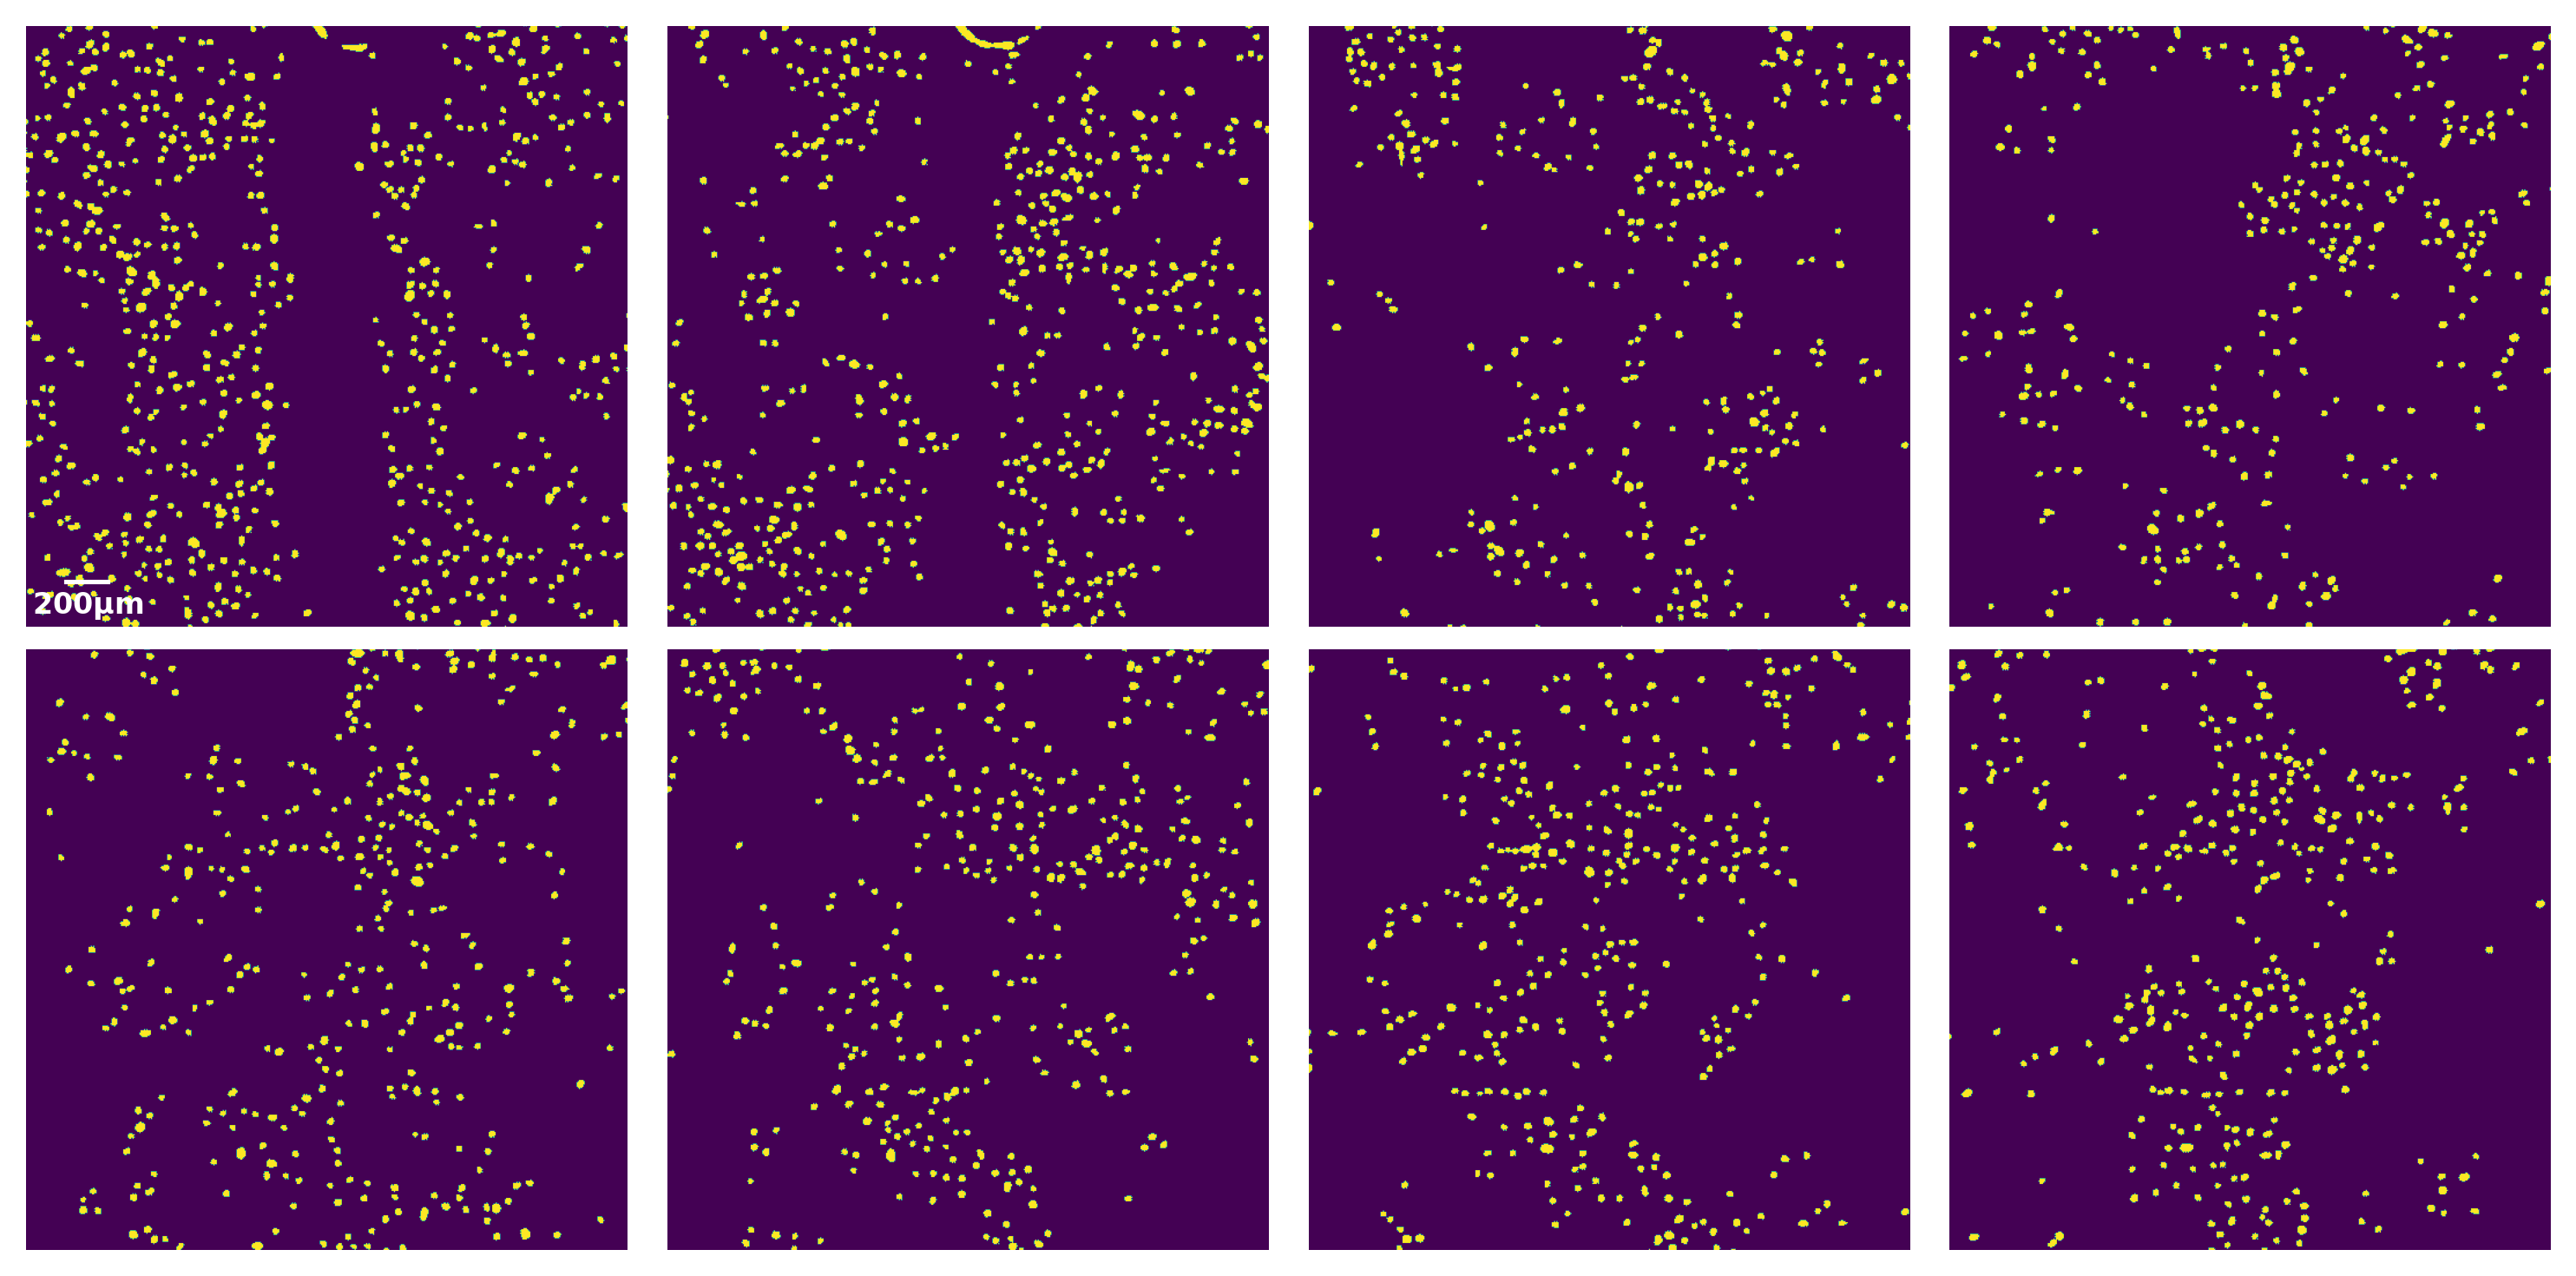

In [13]:
imId = 'L4'
img = segments[imId]
metadata_path = f"/nfs/turbo/umms-indikar/shared/projects/wound_healing/imaging_results/metadata/{imId}.metadata.json"
metadata = load_metadata(metadata_path)

# adjust the viewing frame
frame_shape = img.shape[-2:]
buff = 50
n = np.min(frame_shape) - buff
print(f"{img.shape=} {frame_shape=}")

# set up the scale bar
length = 200
pixels = make_scale_bar(img, metadata, length=length)
print(f"{length=}(micron) {pixels=}")

ntime = 8
nrow = 2
t_idx = np.linspace(10, 96, ntime).astype(int)
channel = 1

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5
fig, axs = plt.subplots(nrow, ntime//nrow)
axs = axs.ravel()

for i, t in enumerate(t_idx):
    timg = img[t, buff:n,  buff:n]
    timg = np.where(timg > 0, 1, 0)
    
    axs[i].imshow(timg, 
                  cmap="viridis")

    axs[i].axis(False)
    # time = int((t * 30) / 60)

    # axs[i].annotate(f"{time}h", 
    #                 xy=(len(timg)-10, len(timg)-10),
    #                 color='w',
    #                 size=13,
    #                 horizontalalignment='right',
    #                 weight='bold',)
    if i == 0:
        scalebar = AnchoredSizeBar(axs[i].transData,
                                   pixels, 
                                   f'{length}' + r'$\bf{\mu m}$', 
                                   loc='lower left', 
                                   color='w',
                                   fontproperties={'weight':'bold',
                                                  'size':8},
                                   frameon=False,
                                   size_vertical=1,)
    
        axs[i].add_artist(scalebar)
        
plt.tight_layout()

img.shape=(3, 97, 1510, 620) frame_shape=(1510, 620)
length=200(micron) pixels=36.710719530102786


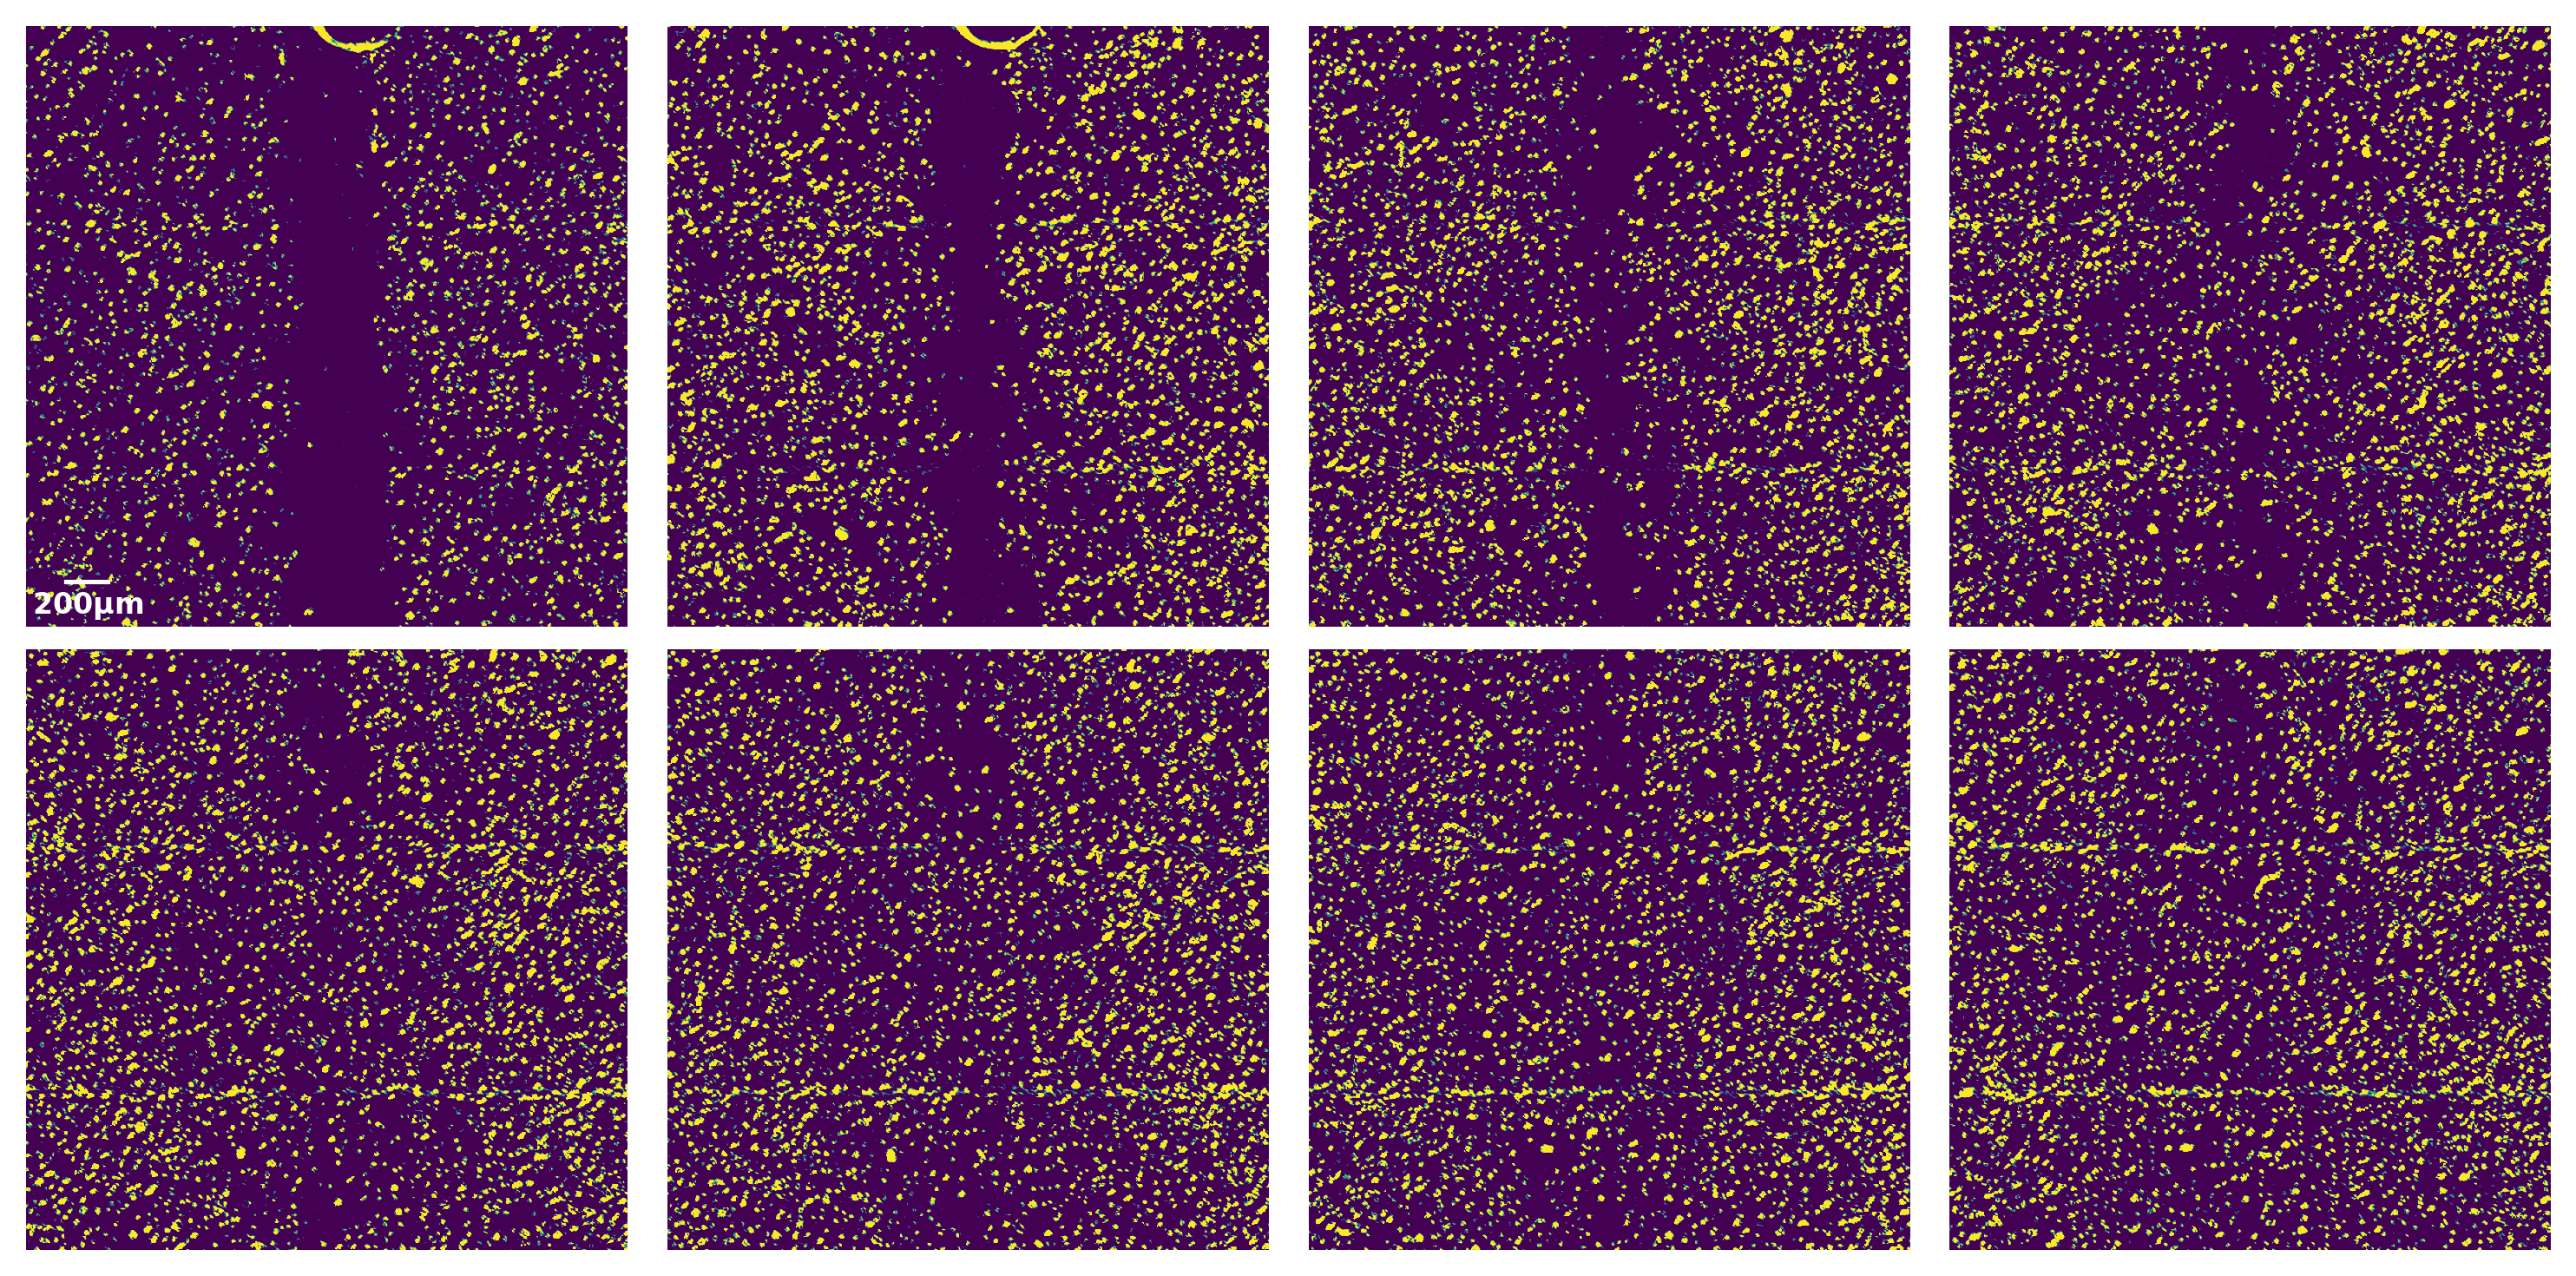

In [26]:
imId = 'L4'
img = images[imId]
metadata_path = f"/nfs/turbo/umms-indikar/shared/projects/wound_healing/imaging_results/metadata/{imId}.metadata.json"
metadata = load_metadata(metadata_path)

# adjust the viewing frame
frame_shape = img.shape[-2:]
buff = 50
n = np.min(frame_shape) - buff
print(f"{img.shape=} {frame_shape=}")

# set up the scale bar
length = 200
pixels = make_scale_bar(img, metadata, length=length)
print(f"{length=}(micron) {pixels=}")

ntime = 8
nrow = 2
t_idx = np.linspace(10, 96, ntime).astype(int)
channel = 1

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5
fig, axs = plt.subplots(nrow, ntime//nrow)
axs = axs.ravel()

for i, t in enumerate(t_idx):
    timg = img[channel, t, buff:n,  buff:n]
    axs[i].imshow(timg, 
                  cmap="viridis", 
                  vmin=5, 
                  vmax=10)

    axs[i].axis(False)
    # time = int((t * 30) / 60)

    # axs[i].annotate(f"{time}h", 
    #                 xy=(len(timg)-10, len(timg)-10),
    #                 color='w',
    #                 size=13,
    #                 horizontalalignment='right',
    #                 weight='bold',)
    if i == 0:
        scalebar = AnchoredSizeBar(axs[i].transData,
                                   pixels, 
                                   f'{length}' + r'$\bf{\mu m}$', 
                                   loc='lower left', 
                                   color='w',
                                   fontproperties={'weight':'bold',
                                                  'size':8},
                                   frameon=False,
                                   size_vertical=1,)
    
        axs[i].add_artist(scalebar)
        
    
plt.tight_layout()

(-0.5, 499.5, 499.5, -0.5)

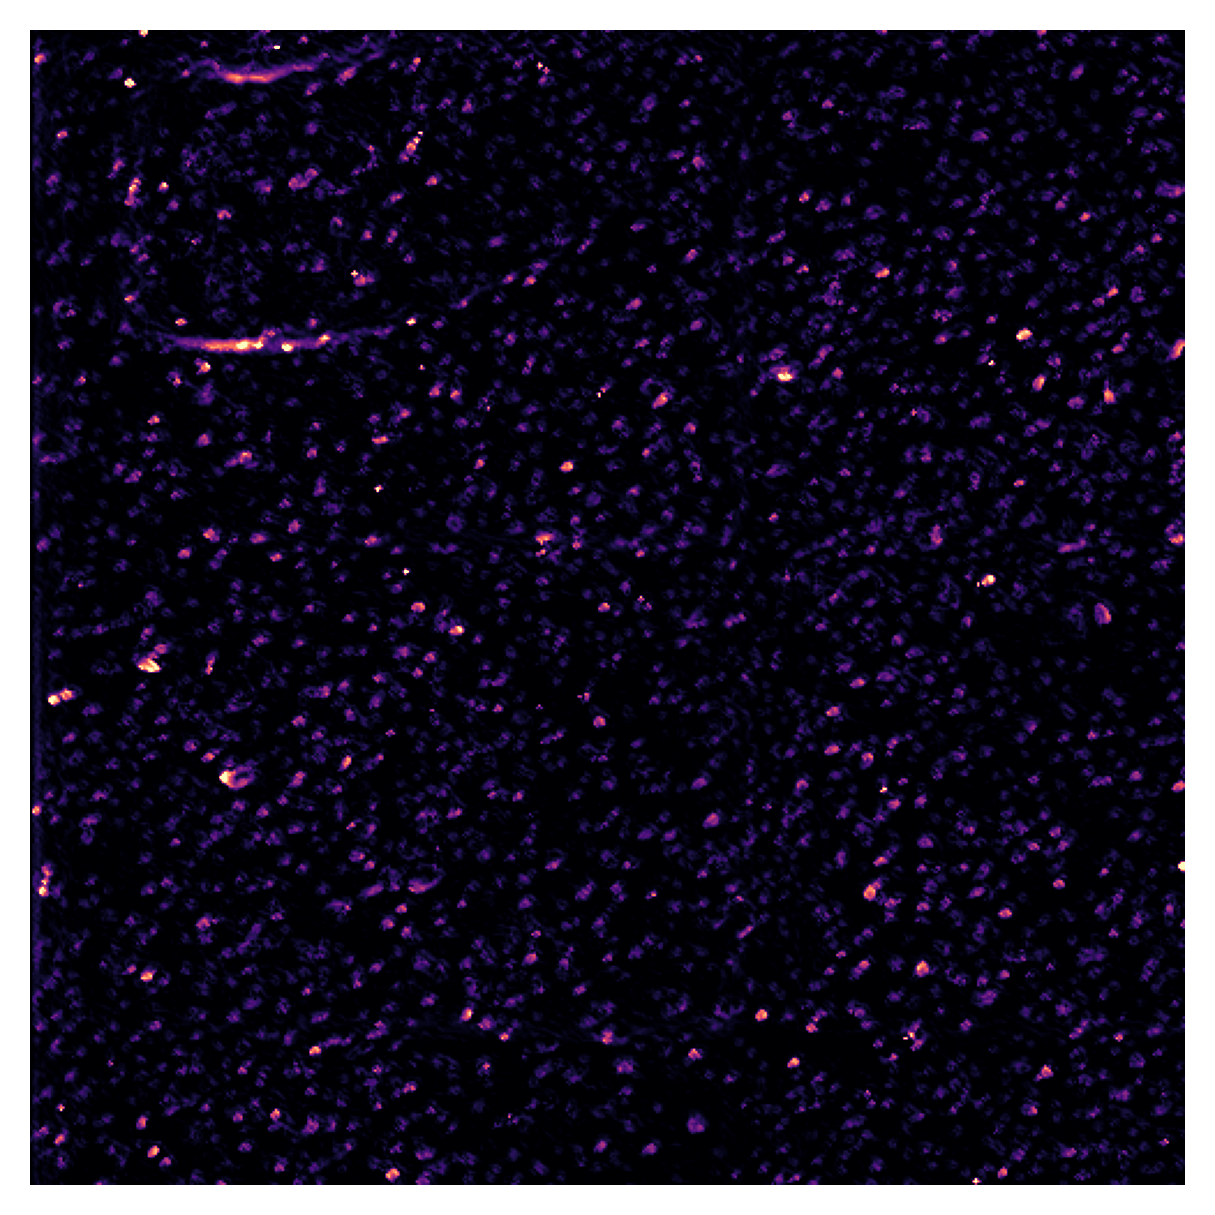

In [197]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

imId = 'CX4'
# img = segments[imId]
img = images[imId][1, :, :, :]

plt.imshow(img[10, 0:500, 0:500],
           cmap="magma",
           vmin=0,
           vmax=80)

ax = plt.gca()
ax.axis(False)

In [ ]:
# 